# Optical character recognition


## Introduction
Optical character recognition is the electronic conversion of images of typed, handwritten or printed text into machine-encoded text, such as from a scanned document, a photo of a document.

In this tutorial, we will go over how to use forte help us manage/process data related to OCR task. We first need to read image containing text from data source and then process it to obtain text. Therefore, we need a reader and a processor in the pipeline. Plus, we also expect that for each character we can locate a bounding box in the original image. Therefore, we use the ontology `forte.data.ontology.top.Link` that links `forte.data.ontology.top.Annotation` and `forte.data.ontology.top.Box`.

In [ ]:
from forte.data.data_pack import DataPack
from forte.pipeline import Pipeline
from forte.data.data_pack import DataPack
from forte.pipeline import Pipeline
from typing import Any, Iterator
from ft.onto.payload_ontology import ImagePayload
from forte.data.base_reader import PackReader
from forte.processors.base.pack_processor import PackProcessor
from forte.common.configuration import Config
from forte.common.resources import Resources
from forte.data.ontology import Annotation
from forte.data.ontology.top import Box, Link
from PIL import Image
import requests
import pytesseract

### OCR Reader

It's essentially a reader that reads image from an url, and load the image into `ImagePayload` in the DataPack.

In [ ]:
class OcrReader(PackReader):
    r"""
    :class:`OcrReader` is designed to read an image
    """
    def _collect(self, image_path) -> Iterator[Any]:  # type: ignore
        r"""Should be called with param ``Image_directory`` which is a path to a
        folder containing Image files.

        Args:
            Image_directory: Image directory containing the files.

        Returns: Iterator over paths to Image files
        """
        # construct ImageMeta and store it in DataPack
        return image_path

    def _parse_pack(self, data_source: str) -> Iterator[DataPack]:
        r"""Takes a raw string and converts into a :class:`~forte.data.data_pack.DataPack`.

        Args:
            data_source: str that contains text of a document.

        Returns: :class:`~forte.data.data_pack.DataPack` containing Document.
        """
        pack: DataPack = DataPack()
        payload_idx = 0
        
        # Read in Image data and store in DataPack
        # add Image payload into DataPack.payloads
        ip = ImagePayload(pack, payload_idx)
        image_data = Image.open(requests.get(data_source, stream=True).raw)
        ip.set_cache(image_data)
        yield pack

## OCR Processor
It analyzes the image in the DataPack ImagePayload, and predict the bounding box for each character. It wraps predicted bounding boxes and characters in forte ontology and write back into the DataPack.

In [ ]:
class OcrProcessor(PackProcessor):
    """
    An audio processor for speaker segmentation.
    """
    def initialize(self, resources: Resources, configs: Config):
        super().initialize(resources, configs)

    def _process(self, input_pack: DataPack):
        image_data = input_pack.image_payloads[0].cache
        ocr_text = pytesseract.image_to_string(image_data)
        input_pack.set_text(ocr_text)
        boxes = pytesseract.image_to_boxes(image_data)
        boxes = boxes.strip().split("\n")
        begin = 0
        for b in boxes:
            b = b.split(" ")
            ch = b[0]
            y1, x1 = int(b[1]), int(b[2])
            y2, x2 = int(b[3]), int(b[4])
            while ocr_text[begin].isspace():
                begin += 1
            if ocr_text[begin] == ch:
                character = Annotation(input_pack, begin, begin+1)
                cy = (y1+y2)/2
                cx = (x1+x2)/2
                height = y2-y1
                width = x2-x1
                box = Box(input_pack, cy, cx, height, width)
                Link(input_pack, character, box)
            else:
                raise ValueError(f"text {ocr_text[begin]} != {ch}")
            begin += 1

Let's first take a look at the image we are going to analyze.

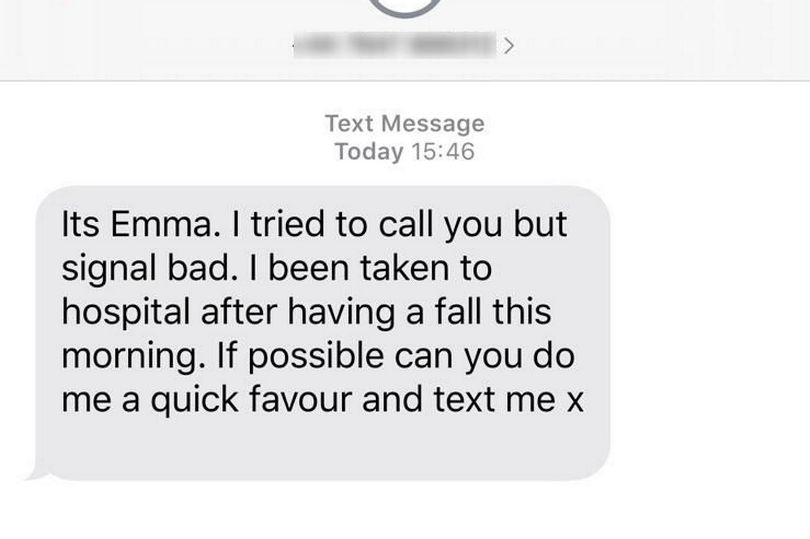

In [ ]:
import IPython
image_url = 'https://raw.githubusercontent.com/asyml/forte/assets/ocr_tutorial/ocr.jpg'
IPython.display.Image(image_url, width = 250)

Let's set up a forte pipeline for the OCR task.

In [ ]:
pipeline = Pipeline[DataPack]()
pipeline.set_reader(
    OcrReader()
)
pipeline.add(OcrProcessor())
pipeline.initialize()
pack = pipeline.process_one([image_url])

links = pack.get(Link)

for link in links:
    ch = link.get_parent()
    print(ch.text) # character
    ch_bb= link.get_child() 
    print(ch_bb.corners, ch_bb.area) # bounding box

T
[(326.0, 408.0), (326.0, 424.0), (338.0, 408.0), (338.0, 424.0)] 192
e
[(339.0, 408.0), (339.0, 420.0), (350.0, 408.0), (350.0, 420.0)] 132
x
[(353.0, 408.0), (353.0, 420.0), (362.0, 408.0), (362.0, 420.0)] 108
t
[(367.0, 408.0), (367.0, 423.0), (372.0, 408.0), (372.0, 423.0)] 75
M
[(383.0, 408.0), (383.0, 424.0), (399.0, 408.0), (399.0, 424.0)] 256
e
[(404.0, 408.0), (404.0, 420.0), (414.0, 408.0), (414.0, 420.0)] 120
s
[(418.0, 408.0), (418.0, 420.0), (427.0, 408.0), (427.0, 420.0)] 108
s
[(431.0, 408.0), (431.0, 420.0), (440.0, 408.0), (440.0, 420.0)] 108
a
[(444.0, 408.0), (444.0, 420.0), (450.0, 408.0), (450.0, 420.0)] 72
g
[(449.0, 408.0), (449.0, 420.0), (454.0, 408.0), (454.0, 420.0)] 60
e
[(458.0, 403.0), (458.0, 420.0), (484.0, 403.0), (484.0, 420.0)] 442
T
[(336.0, 380.0), (336.0, 396.0), (344.0, 380.0), (344.0, 396.0)] 128
o
[(345.0, 380.0), (345.0, 396.0), (360.0, 380.0), (360.0, 396.0)] 240
d
[(363.0, 380.0), (363.0, 392.0), (370.0, 380.0), (370.0, 392.0)] 84
a
[(372.0,